In [22]:
import networkx as nx
import numpy as np
import pandas as pd 
import operator
import matplotlib.pyplot as plt
import random
import pickle

In [23]:
nx_graphs = []
agg_graph = nx.MultiGraph()
venue_df_list = []
for i in range(31):
    # with open(f'..\ATX_Networks\sim_day_{i+1}.gexf') as graph_file:
    nx_graphs.append(nx.read_gexf(f'datasets\ATX_Networks\sim_day_{i+1}.gexf'))
    df = nx.to_pandas_edgelist(nx_graphs[i],source="Source",target="Target")
    df['day'] = i
    venue_df_list.append(df)

concat_venue_df = pd.concat(venue_df_list)
# concat_venue_df.columns = ['source','target','venueid']
concat_venue_df.head()

,Source,Target,hour,id,venueid,time_spent,visits,day
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,2,0,440da2cbf964a52091301fe3,976,18,0
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,2,1,440da2cbf964a52091301fe3,100,2,0
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,4,2,440da2cbf964a52091301fe3,14,2,0
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,5,3,440da2cbf964a52091301fe3,148,3,0
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,5,4,440da2cbf964a52091301fe3,526,9,0


In [144]:
places_df = pd.read_csv("datasets/RVF_ATX_PID_HZ_Places_Lookup.tsv",delimiter='\t')
merged_df = concat_venue_df.merge(places_df, on='venueid')
merged_df.head()

,Source,Target,hour,id,venueid,time_spent,visits,day,venuename,address,...,level1cat,level2catId,level2cat,level3catId,level3cat,chainid,chainname,parentvenueid,zip,sample
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,2,0,440da2cbf964a52091301fe3,976,18,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,2,1,440da2cbf964a52091301fe3,100,2,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,4,2,440da2cbf964a52091301fe3,14,2,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,5,3,440da2cbf964a52091301fe3,148,3,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,5,4,440da2cbf964a52091301fe3,526,9,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all


### Merge with loyalty scores

In [150]:
loyalty_scores = pickle.load(open("graph_files/loyalty_scores.pkl", "rb"))

In [151]:
loyalty_list = []
for tuple in loyalty_scores:
	venueid = tuple[0][0][0]
	score = tuple[1]
	loyalty_list.append((venueid, round(score)))

In [152]:
loyalty_scores = pd.DataFrame(loyalty_list, columns = ["venueid", "loyalty_score"])
# loyalty_scores["loyalty_score"] = pd.Categorical(loyalty_scores.loyalty_score)
# loyalty_scores.head()
# merged_df["loyalty_score"].unique()

loyalty_scores.dtypes

venueid          object
loyalty_score     int64
dtype: object

In [153]:
merged_df = pd.merge(merged_df, loyalty_scores, on = "venueid")

In [154]:
source_set = set(merged_df['Source'].unique())
target_set = set(merged_df['Target'].unique())
node_set = source_set.union(target_set)

In [155]:
size = len(node_set)
node_encodings = np.arange(size)
node_list = list(node_set)

In [156]:
neg_df = pd.read_csv("datasets/neg_samples_180000.csv")
features_df_neg = neg_df.copy()[["Source","Target","venueid","hour","time_spent","visits"]]
features_df_neg = features_df_neg.astype({"hour":"int32","visits":"int32","time_spent":"int32"})
features_df_neg = features_df_neg.merge(places_df[['level1cat','venueid']], on='venueid')
features_df_neg.head()

,Source,Target,venueid,hour,time_spent,visits,level1cat
0,4ed23ffbfe4a8997f5172d7d2da88b7b75357e4c21af6f...,d8e4658adb2cd20d208eb6f089e4c482bf7ec7fa084ea9...,4b8ab9c1f964a520a67c32e3,3,2062,25,Shops & Services
1,cf0b83f6cde68d475abb3d82ed316273ed0856e30ce1ef...,f9e5bde0ec17235ca5e921717b57bc0ede0344fe8760d3...,4b8ab9c1f964a520a67c32e3,23,3325,29,Shops & Services
2,c02f1f8e75c424098241774603eea52222d5b7d4d60c5d...,33283de883dfbbc53475b9dab3dec4a6cb35de0e8ea14d...,4b8ab9c1f964a520a67c32e3,23,189,41,Shops & Services
3,15cf3f776ad9e4dbccb533242c58b53fc61ef384f5ea5d...,113b3c657ecd221fb4cbbb5b4b02f0c1b128b33862fa29...,4b8ab9c1f964a520a67c32e3,14,2073,22,Shops & Services
4,c58106b1ca52af9eed41cf74b5f76299bc5210076f5831...,21d4302b1c13e01be5e9a10c55a7cb39b8fe0332e68c04...,4b8ab9c1f964a520a67c32e3,22,337,57,Shops & Services


In [157]:
features_df_pos = merged_df.copy()[["Source","Target","venueid","hour","time_spent","visits","day", "loyalty_score"]]
features_df_pos = features_df_pos.merge(places_df[['level1cat','venueid']], on='venueid')
features_df_pos.head()

,Source,Target,venueid,hour,time_spent,visits,day,loyalty_score,level1cat
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,440da2cbf964a52091301fe3,2,976,18,0,19,Travel & Transport
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,440da2cbf964a52091301fe3,2,100,2,0,19,Travel & Transport
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,440da2cbf964a52091301fe3,4,14,2,0,19,Travel & Transport
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,440da2cbf964a52091301fe3,5,148,3,0,19,Travel & Transport
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,440da2cbf964a52091301fe3,5,526,9,0,19,Travel & Transport


In [158]:
node_encoding_df = pd.DataFrame({'Node':node_list,'Source_Encoding':node_encodings})
encoded_df = features_df_pos.merge(node_encoding_df, left_on='Source',right_on='Node', how='left')
node_encoding_df = pd.DataFrame({'Node':node_list,'Target_Encoding':node_encodings})
encoded_df = encoded_df.merge(node_encoding_df, left_on='Target',right_on='Node', how ='left')
encoded_df_pos = encoded_df.drop(['Node_x','Node_y'],axis=1)
#preserve temporal day order by sorting on day
encoded_df_pos = encoded_df_pos.sort_values(by='day').reset_index(drop=True)
#impose source<target ordering to address source-target target-source duplicates
encoded_df_pos.loc[encoded_df_pos['Source_Encoding']>encoded_df_pos['Target_Encoding'],['Source_Encoding','Target_Encoding']] = encoded_df_pos.loc[encoded_df_pos['Source_Encoding']>encoded_df_pos['Target_Encoding'],['Target_Encoding','Source_Encoding']].values


In [159]:
node_encoding_df = pd.DataFrame({'Node':node_list,'Source_Encoding':node_encodings})
encoded_df = features_df_neg.merge(node_encoding_df, left_on='Source',right_on='Node',how = 'left')
node_encoding_df = pd.DataFrame({'Node':node_list,'Target_Encoding':node_encodings})
encoded_df = encoded_df.merge(node_encoding_df, left_on='Target',right_on='Node', how = 'left')
encoded_df_neg = encoded_df.drop(['Node_x','Node_y'],axis=1)
#impose source<target ordering to address source-target target-source duplicates
encoded_df_neg.loc[encoded_df_neg['Source_Encoding']>encoded_df_neg['Target_Encoding'],['Source_Encoding','Target_Encoding']] = encoded_df_neg.loc[encoded_df_neg['Source_Encoding']>encoded_df_neg['Target_Encoding'],['Target_Encoding','Source_Encoding']].values

In [160]:
encoded_df_pos = encoded_df_pos.drop(['Source','Target','day'],axis=1)
encoded_df_neg = encoded_df_neg.drop(['Source','Target'],axis=1)
encoded_df_pos.head()

,venueid,hour,time_spent,visits,loyalty_score,level1cat,Source_Encoding,Target_Encoding
0,440da2cbf964a52091301fe3,2,976,18,19,Travel & Transport,5350,11417
1,4b3f8ef6f964a5200ea925e3,19,30,3,2,Shops & Services,11845,18915
2,4b3f8ef6f964a5200ea925e3,19,33,3,2,Shops & Services,11845,25126
3,4b3f8ef6f964a5200ea925e3,18,12,2,2,Shops & Services,4768,9171
4,4b3f8ef6f964a5200ea925e3,18,9,3,2,Shops & Services,1247,9171


In [161]:
# merged_df['level1cat'].value_counts()
encoded_df_pos['level1cat'] = encoded_df_pos['level1cat'].astype('category')
one_hot = pd.get_dummies(encoded_df_pos.level1cat,prefix="cat")
encoded_df_pos = encoded_df_pos.join(one_hot)
encoded_df_pos.columns

Index(['venueid', 'hour', 'time_spent', 'visits', 'loyalty_score', 'level1cat',
       'Source_Encoding', 'Target_Encoding', 'cat_Arts & Entertainment',
       'cat_Colleges & Universities', 'cat_Events', 'cat_Food',
       'cat_Nightlife Spots', 'cat_Outdoors & Recreation',
       'cat_Professional & Other Places', 'cat_Residences',
       'cat_Shops & Services', 'cat_Travel & Transport'],
      dtype='object')

In [162]:
encoded_df_neg['level1cat'] = encoded_df_neg['level1cat'].astype('category')
one_hot = pd.get_dummies(encoded_df_neg.level1cat,prefix="cat")
encoded_df_neg = encoded_df_neg.join(one_hot)
encoded_df_neg = pd.merge(encoded_df_neg, loyalty_scores, on = "venueid")
encoded_df_neg.columns

Index(['venueid', 'hour', 'time_spent', 'visits', 'level1cat',
       'Source_Encoding', 'Target_Encoding', 'cat_Arts & Entertainment',
       'cat_Colleges & Universities', 'cat_Events', 'cat_Food',
       'cat_Nightlife Spots', 'cat_Outdoors & Recreation',
       'cat_Professional & Other Places', 'cat_Residences',
       'cat_Shops & Services', 'cat_Travel & Transport', 'loyalty_score'],
      dtype='object')

### Binning time values

In [163]:
# df.loc[df["hour"] <=8]
encoded_df_pos["binned_time"] = pd.cut(encoded_df_pos["hour"], bins = [0, 8, 16, 25], labels = [0, 1, 2], include_lowest = True)
encoded_df_neg["binned_time"] = -1

In [164]:
encoded_df_pos["binned_time"].unique()

[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

In [165]:
encoded_df_pos[["hour", "binned_time"]].groupby("binned_time", dropna = False).head()
# encoded_df_pos[["hour", "binned_time"]].groupby("hour").count()

,hour,binned_time
0,2,0
1,19,2
2,19,2
3,18,2
4,18,2
5,17,2
27,14,1
28,14,1
29,14,1
31,16,1


In [166]:
encoded_df_pos.head()

,venueid,hour,time_spent,visits,loyalty_score,level1cat,Source_Encoding,Target_Encoding,cat_Arts & Entertainment,cat_Colleges & Universities,cat_Events,cat_Food,cat_Nightlife Spots,cat_Outdoors & Recreation,cat_Professional & Other Places,cat_Residences,cat_Shops & Services,cat_Travel & Transport,binned_time
0,440da2cbf964a52091301fe3,2,976,18,19,Travel & Transport,5350,11417,0,0,0,0,0,0,0,0,0,1,0
1,4b3f8ef6f964a5200ea925e3,19,30,3,2,Shops & Services,11845,18915,0,0,0,0,0,0,0,0,1,0,2
2,4b3f8ef6f964a5200ea925e3,19,33,3,2,Shops & Services,11845,25126,0,0,0,0,0,0,0,0,1,0,2
3,4b3f8ef6f964a5200ea925e3,18,12,2,2,Shops & Services,4768,9171,0,0,0,0,0,0,0,0,1,0,2
4,4b3f8ef6f964a5200ea925e3,18,9,3,2,Shops & Services,1247,9171,0,0,0,0,0,0,0,0,1,0,2


In [167]:
encoded_df_neg.head()

,venueid,hour,time_spent,visits,level1cat,Source_Encoding,Target_Encoding,cat_Arts & Entertainment,cat_Colleges & Universities,cat_Events,cat_Food,cat_Nightlife Spots,cat_Outdoors & Recreation,cat_Professional & Other Places,cat_Residences,cat_Shops & Services,cat_Travel & Transport,loyalty_score,binned_time
0,4b8ab9c1f964a520a67c32e3,3,2062,25,Shops & Services,8392,14779,0,0,0,0,0,0,0,0,1,0,1,-1
1,4b8ab9c1f964a520a67c32e3,23,3325,29,Shops & Services,17415,22384,0,0,0,0,0,0,0,0,1,0,1,-1
2,4b8ab9c1f964a520a67c32e3,23,189,41,Shops & Services,3395,19222,0,0,0,0,0,0,0,0,1,0,1,-1
3,4b8ab9c1f964a520a67c32e3,14,2073,22,Shops & Services,9410,26582,0,0,0,0,0,0,0,0,1,0,1,-1
4,4b8ab9c1f964a520a67c32e3,22,337,57,Shops & Services,4203,25926,0,0,0,0,0,0,0,0,1,0,1,-1


# Training

In [168]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from datetime import datetime
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier, Pool

In [169]:
def results(model, X_train, X_valid,y_train, y_valid):
    soft_probs = model.predict_proba(X_valid)
    # print(soft_probs)
    valid_auc = roc_auc_score(y_valid, soft_probs, multi_class = "ovo")
    # print(f"Training accuracy: {valid_auc}")
    train_preds = model.predict(X_train)
    acc = accuracy_score(y_train, train_preds)
    print(f"Training accuracy: {acc}")
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    
    print(f"Validation accuracy: {acc}")
    cf_matrix = confusion_matrix(y_valid, preds)
    print(classification_report(y_valid,preds))
    return cf_matrix

In [170]:
def plot_confusion(cf_matrix):
#     group_names = ['-1','0','1','2']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v2}\n{v3}" for v2, v3 in
            zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(4,4)
    plt.clf()
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

In [171]:
# X = encoded_df.drop(['venueid','link','level1cat','day'],axis=1)

X_train_pos = encoded_df_pos[:int(0.75*len(encoded_df_pos))]
X_valid_pos = encoded_df_pos[int(0.75*len(encoded_df_pos)):]
X_train_neg = encoded_df_neg[:int(0.75*len(encoded_df_neg))]
X_valid_neg = encoded_df_neg[int(0.75*len(encoded_df_neg)):]
X_train_total = X_train_pos.append(X_train_neg)
X_valid_total = X_valid_pos.append(X_valid_neg)

X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
X_valid_total = X_valid_total.sample(frac=1).reset_index(drop=True)

y_train_total = X_train_total['binned_time']
y_valid_total = X_valid_total['binned_time']
X_train_total = X_train_total.drop(['hour', 'venueid', 'level1cat', 'binned_time'], axis=1)
X_valid_total = X_valid_total.drop(['hour', 'venueid', 'level1cat', 'binned_time'], axis=1)

In [172]:
X_train_pos["binned_time"].unique()

[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

In [173]:
len(X_train_total.columns)

15

In [174]:
cat_indices = range(len(X_train_total.columns))
model_cat = CatBoostClassifier(cat_features=cat_indices,
                                verbose=100,
                                eval_metric='AUC:hints=skip_train~false',
                                loss_function='MultiClass'
                                )

In [175]:
X_train_total.head()

,time_spent,visits,loyalty_score,Source_Encoding,Target_Encoding,cat_Arts & Entertainment,cat_Colleges & Universities,cat_Events,cat_Food,cat_Nightlife Spots,cat_Outdoors & Recreation,cat_Professional & Other Places,cat_Residences,cat_Shops & Services,cat_Travel & Transport
0,1123,31,1,9990,15382,0,0,0,0,0,0,0,0,1,0
1,0,2,1,10067,13187,0,0,0,0,0,1,0,0,0,0
2,356,6,19,8592,18450,0,0,0,0,0,0,0,0,0,1
3,1388,41,0,14240,17001,0,0,0,1,0,0,0,0,0,0
4,1788,44,1,497,5585,0,0,0,0,0,0,0,0,1,0


In [177]:
model_cat.fit(X_train_total,y_train_total)

Learning rate set to 0.105988
0:	learn: 0.7775045	total: 389ms	remaining: 6m 28s
100:	learn: 0.9441622	total: 35.7s	remaining: 5m 17s
200:	learn: 0.9500039	total: 1m 11s	remaining: 4m 45s
300:	learn: 0.9524786	total: 1m 47s	remaining: 4m 9s
400:	learn: 0.9541873	total: 2m 21s	remaining: 3m 31s
500:	learn: 0.9556294	total: 2m 55s	remaining: 2m 54s
600:	learn: 0.9568402	total: 3m 28s	remaining: 2m 18s
700:	learn: 0.9580413	total: 4m 2s	remaining: 1m 43s
800:	learn: 0.9592237	total: 4m 38s	remaining: 1m 9s
900:	learn: 0.9603013	total: 5m 12s	remaining: 34.3s
999:	learn: 0.9613743	total: 5m 46s	remaining: 0us


In [178]:
cf_matrix = results(model_cat,X_train_total, X_valid_total, y_train_total, y_valid_total)

Training accuracy: 0.9913082411111436
Validation accuracy: 0.8121313581592727
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99     45000
           0       0.45      0.17      0.25      3126
           1       0.73      0.83      0.78     39064
           2       0.49      0.36      0.41     15552

    accuracy                           0.81    102742
   macro avg       0.66      0.59      0.61    102742
weighted avg       0.80      0.81      0.80    102742



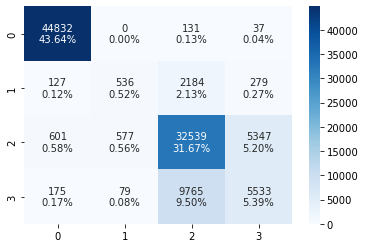

In [179]:
plot_confusion(cf_matrix)

## Feature Importance

In [181]:
pd.DataFrame({'feature_importance': model_cat.get_feature_importance(), 
              'feature_names': X_train_total.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
0,21.645995,time_spent
2,19.722884,loyalty_score
3,17.041298,Source_Encoding
1,16.961699,visits
4,16.052628,Target_Encoding
13,3.308111,cat_Shops & Services
14,1.320664,cat_Travel & Transport
11,1.222049,cat_Professional & Other Places
8,1.029575,cat_Food
10,0.788229,cat_Outdoors & Recreation
